<a href="https://colab.research.google.com/github/GerasimGerasimov/generator-exciter-model/blob/main/%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%BE%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Модель синхронного генератора.**

# Описание
1. Турбина мощностью 6МВТ вращает турбогенератор ТГ, номинальная скорость вращения 3000 об мин, для частоты 50Гц
2. Параметры ТГ: мощность 6МВА и номинальным напряжением 10000В, ток возбуждения холостого хода 110А
3. К статору ТГ подключен 3-х фазный трансформатор собсвенных нужд Т1.
4. Параметры Т1: номинальное линейное напряжение первичной обмотки 10000В, номинальное линейное напряжение вторичной обмотки 380В
5. от вторичной обмотки трансформатора Т1 питается ТВ - тиристорный выпрямитель
6. ТВ собран по мостовой схеме
7. Статор ТГ подключается к сети вывоковольтным выключателем В1
8. ТГ, через В1 подключен к сетевому трансформатору ТС 10кВ/500кВ который в свою очередь подключен к Линии электропередачи ЛЭ1
9. Параметры ЛЭ1 приведенные к напряжению 500 кВ: X1 = 100Ом, R1 = 3.6 Ом
10. ТВ управляется ПИД регулятором, в режиме стабилизации напряжения статора с заданным статизмом 5%

В начальных условиях, В1 отключен (ТГ отключен от сети), хочу увидеть переходный процесс напряжения стотора при подаче начального возбуждения током холостого хода

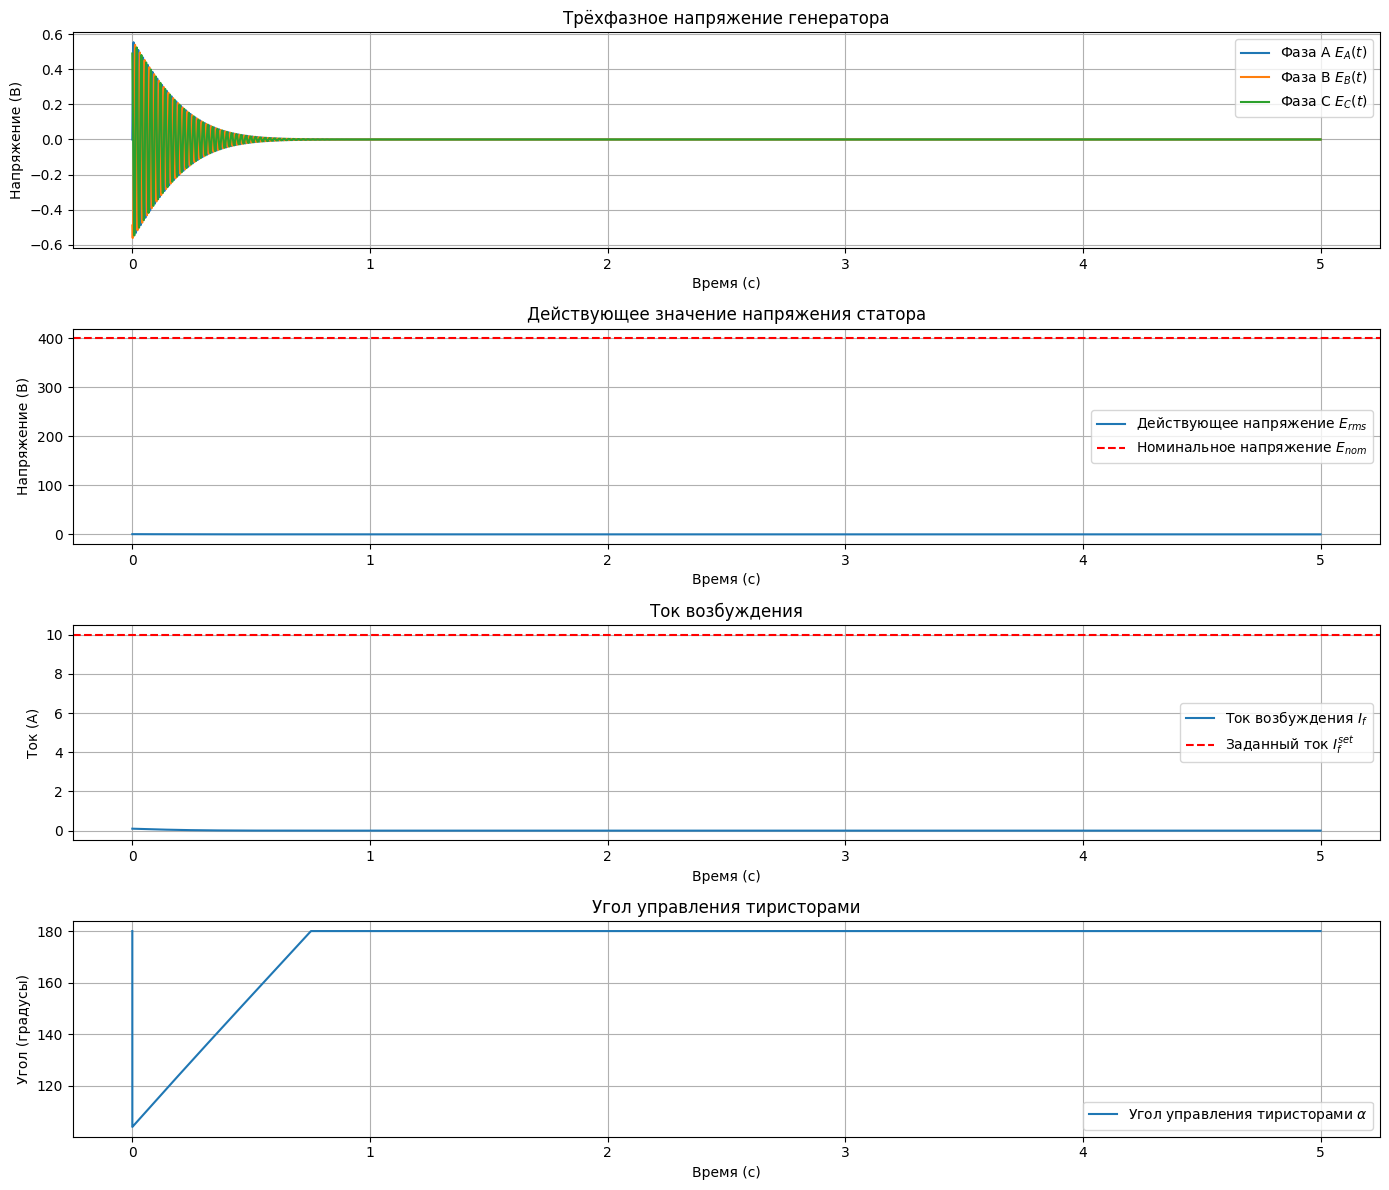

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры генератора и системы
L_f = 0.5       # Индуктивность обмотки возбуждения, Гн
R_f = 1.0       # Сопротивление обмотки возбуждения, Ом
I_f_idle = 100.0  # ток холостого хода
k_f = 400 * np.sqrt(2) / I_f_idle  # Коэффициент усиления магнитного потока (В/А)
E_0 = 0.0       # Остаточная намагниченность, В
E_nom = 400.0   # Номинальное напряжение статора (действующее значение), В
I_f_set = 10.0   # Заданный ток возбуждения, А
V_in = 0.0    # Входное напряжение на тиристоры, В
E_rms = 0.0
f = 50.0        # Частота генерации, Гц
omega = 2 * np.pi * f  # Угловая частота, рад/с
dt = 0.0001     # Шаг времени для микроконтроллера (0.1 мс)
t_end = 5.0     # Время моделирования, секунд
steps = int(t_end / dt)  # Количество шагов

# Параметры ПИД-регулятора
K_p = 10.5       # Пропорциональный коэффициент
K_i = 10.0     # Интегральный коэффициент
K_d = 0.01      # Действие дифференциального звена

# Логирование данных
time = np.linspace(0, t_end, steps)  # Временной массив
I_f_log = np.zeros(steps)            # Лог тока возбуждения
alpha_log = np.zeros(steps)          # Лог угла управления
E_rms_log = np.zeros(steps)          # Лог RMS-напряжения статора
E_A_log, E_B_log, E_C_log = np.zeros(steps), np.zeros(steps), np.zeros(steps)

# Начальные значения
I_f = 0.1       # Начальный ток возбуждения
alpha = 0       # Начальный угол управления (в градусах)
integral_error = 0  # Интегральная ошибка (для ПИД)
prev_error = 0      # Предыдущая ошибка (для производной)

# Основной цикл моделирования
for i in range(steps):
    t = i * dt

    V_in = E_rms
    # Расчёт напряжения тиристоров
    E_s = V_in * np.cos(np.deg2rad(alpha))

    # Дифференциальное уравнение для тока возбуждения
    dI_f_dt = (E_s - R_f * I_f) / L_f
    if I_f <= 0 and dI_f_dt < 0:  # Ограничение: ток возбуждения не может быть отрицательным
        dI_f_dt = 0
    I_f += dI_f_dt * dt  # Обновление значения тока возбуждения

    # ПИД-регулятор
    error = I_f_set - I_f  # Текущая ошибка
    integral_error += error * dt  # Интегральная составляющая
    derivative_error = (error - prev_error) / dt  # Производная ошибки
    prev_error = error  # Сохранение ошибки для следующего шага

    # Вычисление нового значения угла управления
    alpha = K_p * error + K_i * integral_error + K_d * derivative_error
    alpha = np.clip(alpha, 0, 180)  # Ограничение угла управления [0°, 180°]

    # Расчёт напряжения статора
    E_peak = k_f * I_f + E_0  # Пиковое значение напряжения статора
    E_rms = E_peak / np.sqrt(2)  # Действующее значение (RMS) напряжения статора

    # Генерация трёхфазного напряжения
    E_A = E_peak * np.sin(omega * t)
    E_B = E_peak * np.sin(omega * t - 2 * np.pi / 3)
    E_C = E_peak * np.sin(omega * t + 2 * np.pi / 3)

    # Логирование данных
    I_f_log[i] = I_f
    alpha_log[i] = alpha
    E_rms_log[i] = E_rms
    E_A_log[i], E_B_log[i], E_C_log[i] = E_A, E_B, E_C

# Построение графиков
plt.figure(figsize=(14, 12))

# График трёхфазного напряжения
plt.subplot(4, 1, 1)
plt.plot(time, E_A_log, label="Фаза A $E_A(t)$")
plt.plot(time, E_B_log, label="Фаза B $E_B(t)$")
plt.plot(time, E_C_log, label="Фаза C $E_C(t)$")
plt.title("Трёхфазное напряжение генератора")
plt.xlabel("Время (с)")
plt.ylabel("Напряжение (В)")
plt.legend()
plt.grid()

# График действующего значения напряжения
plt.subplot(4, 1, 2)
plt.plot(time, E_rms_log, label="Действующее напряжение $E_{rms}$")
plt.axhline(E_nom, color='r', linestyle='--', label="Номинальное напряжение $E_{nom}$")
plt.title("Действующее значение напряжения статора")
plt.xlabel("Время (с)")
plt.ylabel("Напряжение (В)")
plt.legend()
plt.grid()

# График тока возбуждения
plt.subplot(4, 1, 3)
plt.plot(time, I_f_log, label="Ток возбуждения $I_f$")
plt.axhline(I_f_set, color='r', linestyle='--', label="Заданный ток $I_f^{set}$")
plt.title("Ток возбуждения")
plt.xlabel("Время (с)")
plt.ylabel("Ток (А)")
plt.legend()
plt.grid()

# График угла управления тиристорами
plt.subplot(4, 1, 4)
plt.plot(time, alpha_log, label="Угол управления тиристорами $\\alpha$")
plt.title("Угол управления тиристорами")
plt.xlabel("Время (с)")
plt.ylabel("Угол (градусы)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()